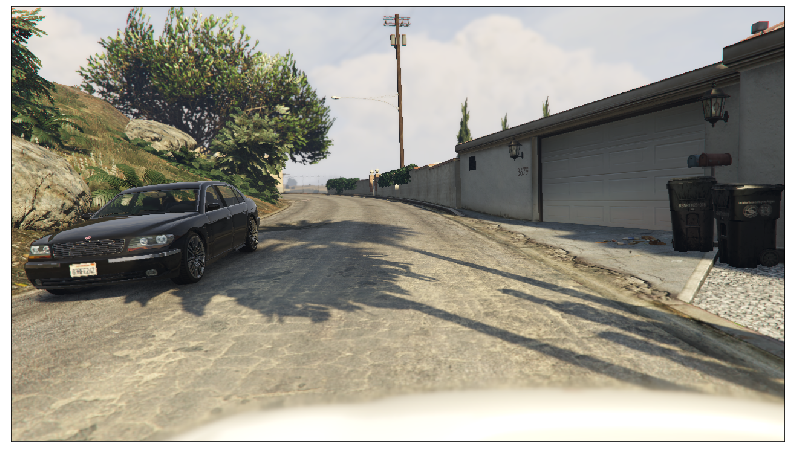

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from tqdm.notebook import tqdm, trange

import sys
sys.path.append('../')

from depth_Functions import (
    show_img,
    show_array_of_images,
    show_function,
    import_raw_colour_image
)

from Feature_Extraction import (
    mask,
    texture_variation,
    haze,
    create_kernels,
    texture_gradients,
    calc_thresholds,
    filters,
    create_local_feature_vector,
    create_feature_vector,
)

bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr);

# Theory

In accordance with [3-D Depth Reconstruction from a Single Still Image](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) we need to get the feature vector of a patch.

We obtain a vector of length 34. A standard and squared version of:

1. 9 texture variations:
    - Each texture variation is obtained using one of the 9 Laws' masks of the intensity
1. 2 Haze variations:
    - 1st Laws' mask applied to the red difference and blue difference
1. 6 texture gradients:
    - Edge detection at angle intervals of $30^\circ$

# YCbCR

Convert the image from BGR to YCrCb:
1. Y: Intensity (luminance)
1. Cr: Red difference
1. Cb: Blue difference

To reduce the noise levels of the measurements we can apply a Gaussian blur to the image.

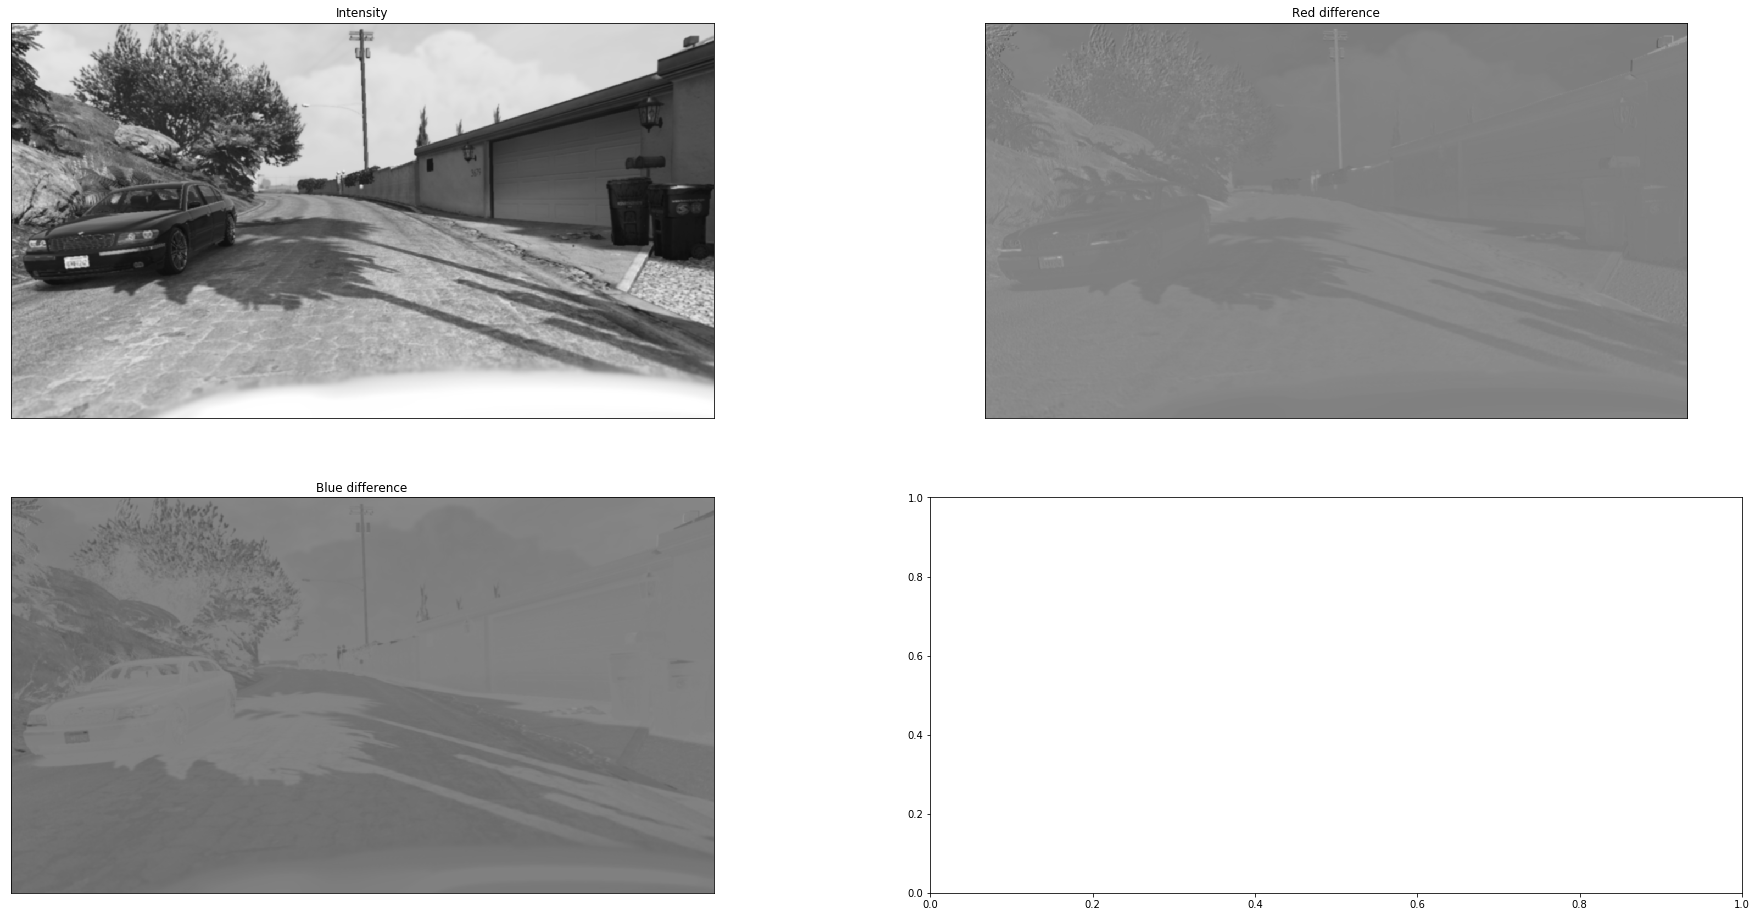

In [22]:
ycc = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb) 
ycc_blur = cv2.GaussianBlur(ycc, (5, 5), 0)
show_array_of_images([ycc_blur], split_channels=True, titles=['Intensity', 'Red difference', 'Blue difference'])

As we'll be carrying out different implementations on each channel, we'll separate them into different arrays

In [4]:
y, cr, cb = cv2.split(ycc_blur)

# Laws' Mask 

[Based on](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect12.pdf)

In [5]:
filters

[array([1, 4, 6, 4, 1]),
 array([-1, -2,  0,  2,  1]),
 array([-1,  0,  2,  0, -1]),
 array([ 1, -4,  6, -4,  1])]

In [6]:
show_function(mask)

def mask(image, first, second=None):
    if second is None:
        return cv2.filter2D(image, -1, filters[first].reshape(5,1)*filters[first])
    else:
        filter1 = cv2.filter2D(image, -1, filters[first].reshape(5,1)*filters[second])
        filter2 = cv2.filter2D(image, -1, filters[second].reshape(5,1)*filters[first])
        return (filter1 + filter2)/2

In [7]:
show_function(texture_variation)

def texture_variation(image_intensity):
    level, edge, spot, ripple = 0, 1, 2, 3
    masks =  [
                mask(image_intensity, level, edge),
                mask(image_intensity, level, ripple),
                mask(image_intensity, edge, spot),
                mask(image_intensity, spot),
                mask(image_intensity, ripple),
                mask(image_intensity, level, spot),
                mask(image_intensity, edge),
                mask(image_intensity, edge, ripple),
                mask(image_intensity, spot, ripple),
             ]
    
    return masks

In [8]:
show_function(haze)
show_function(texture_gradients)

def haze(cr, cb):
    return [mask(cr, 0, 1), mask(cb, 0, 1)]

def texture_gradients(image, d_angle):
    gradX = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0) # reveal vertical edges
    gradY = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1) # reveal horizontal edges

    grad = cv2.convertScaleAbs(np.sqrt(gradX**2 + gradY**2))
    angles = np.mod(np.arctan(gradY/(gradX+1e-10)) * 180/np.pi + 180, 180)  # mod() for unsigned gradients 

    gradients = np.zeros((180//d_angle,*grad.shape))

    for y in range(len(grad)):
        for x in range(len(grad[y])):
            i = int(angles[y,x]/d_angle)
            gradients[i,y,x] = grad[y,x]
    
    return gradients

In [9]:
laws = texture_variation(y) + haze(cr, cb)

In [10]:
laws[0].shape

(720, 1280)

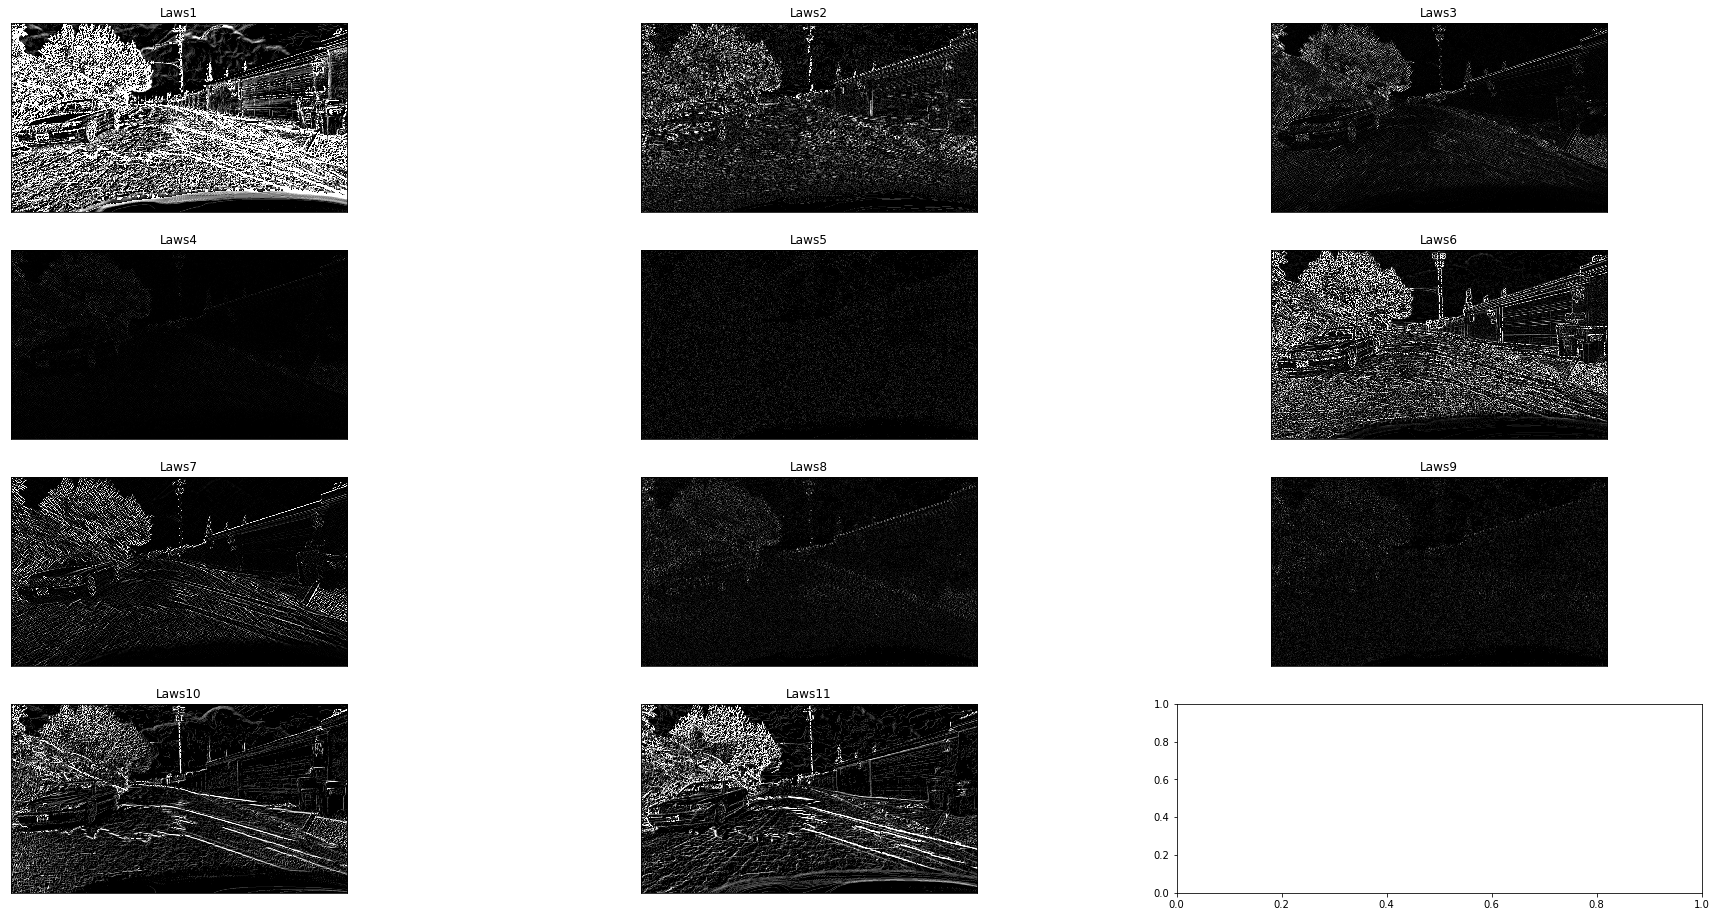

In [11]:
show_array_of_images(laws, titles=[f'Laws{i}' for i in range(1,12)])

# Edge detection

The current implementation for gradient detection is to use sobel edge detection to get the overall edge detection. We then split the edges into bins based on the angle of the gradient.

In [12]:
show_function(texture_gradients)

def texture_gradients(image, d_angle):
    gradX = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0) # reveal vertical edges
    gradY = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1) # reveal horizontal edges

    grad = cv2.convertScaleAbs(np.sqrt(gradX**2 + gradY**2))
    angles = np.mod(np.arctan(gradY/(gradX+1e-10)) * 180/np.pi + 180, 180)  # mod() for unsigned gradients 

    gradients = np.zeros((180//d_angle,*grad.shape))

    for y in range(len(grad)):
        for x in range(len(grad[y])):
            i = int(angles[y,x]/d_angle)
            gradients[i,y,x] = grad[y,x]
    
    return gradients

In [13]:
edges = texture_gradients(y, 30)

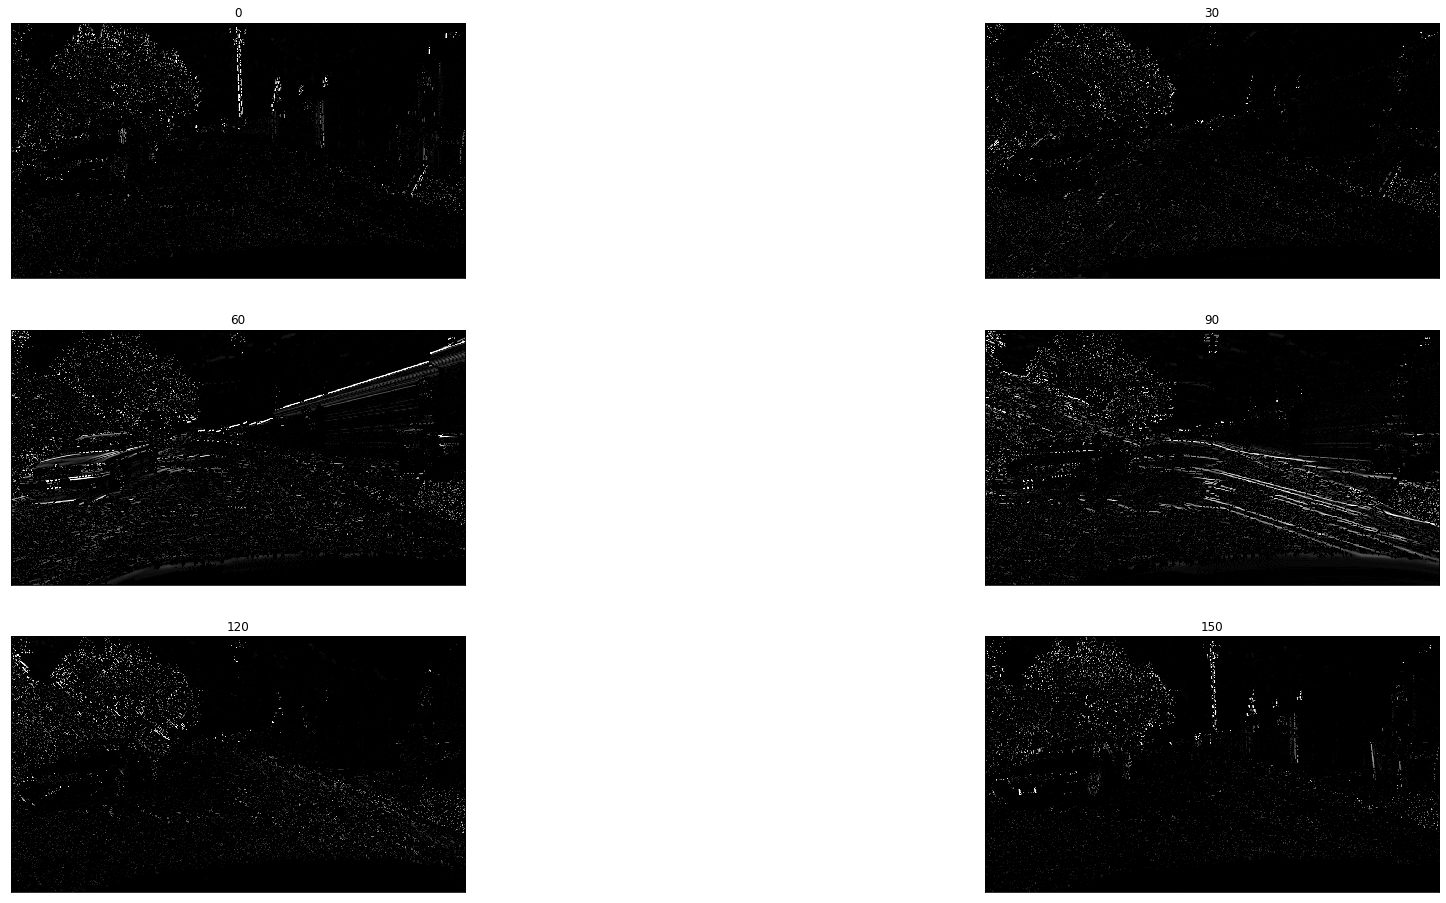

In [15]:
show_array_of_images(list(edges),titles = [i for i in range(0,180,30)])